In [1]:
import pandas as pd
import numpy as np
from coffea import util
import itertools
import os, sys
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("CMS")

sys.path.append('../python/')
from functions import loadCoffeaFile, getLabelMap, getCoffeaFilenames, plotBackgroundEstimate, getHist


## Scale factors and IOV

In [2]:
IOVs = ['2016']

lumi = {
    "2016APV": 19800.,
    "2016": 16120., #35920 - 19800
    "2016all": 35920,
    "2017": 41530.,
    "2018": 59740.
}

t_BR = 0.6741
ttbar_BR = 0.4544 #PDG 2019
ttbar_xs1 = 831.76 * (0.09210) #pb For ttbar mass from 700 to 1000
ttbar_xs2 = 831.76 * (0.02474) #pb For ttbar mass from 1000 to Inf
toptag_sf = 0.9
toptag_kf = 0.7 #0.7
qcd_xs = 1370000000.0 #pb From https://cms-gen-dev.cern.ch/xsdb



## analysis categories

In [3]:
# analysis categories #

label_dict =  getLabelMap()
label_to_int_dict = {label: i for i, label in label_dict.items()}

signal_cats = [ i for i, label in label_dict.items() if '2t' in label]
pretag_cats = [ i for i, label in label_dict.items() if 'pre' in label]


In [4]:
label_dict

{0: 'at0bcen',
 1: 'at0bfwd',
 2: 'at1bcen',
 3: 'at1bfwd',
 4: 'at2bcen',
 5: 'at2bfwd',
 6: 'pret0bcen',
 7: 'pret0bfwd',
 8: 'pret1bcen',
 9: 'pret1bfwd',
 10: 'pret2bcen',
 11: 'pret2bfwd',
 12: '2t0bcen',
 13: '2t0bfwd',
 14: '2t1bcen',
 15: '2t1bfwd',
 16: '2t2bcen',
 17: '2t2bfwd'}

## make plot image filenames

In [5]:
directories = [
    'images/png/closureTest/2016all',
    'images/png/closureTest/2016APV',
    'images/png/closureTest/2016',
    'images/png/closureTest/2017',
    'images/png/closureTest/2018',
    'images/pdf/closureTest/2016all',
    'images/pdf/closureTest/2016APV',
    'images/pdf/closureTest/2016',
    'images/pdf/closureTest/2017',
    'images/pdf/closureTest/2018',
]


for path in directories:
    if not os.path.exists(path):
        os.makedirs(path)

## functions

In [6]:
def getHist(hname, ds, bkgest, year, sum_axes=['anacat'], integrate_axes={}):
    
    ######################################################################################
    # hname = histogram name (example: 'ttbarmass')                                      #
    # ds = dataset name (example: 'JetHT')                                               #
    # bkgest = boolean, True if bkg estimate applied                                     #
    # year = '2016APV' or '2016' or '2017' or '2018'                                     #
    # sum_axes = names of axes to sum over for scikit-hep/hist histogram                 #
    # integrate_axes = range to integrate over axis (example: {'anacat': [0,1,2,3,4,5]}) #
    ######################################################################################    

    
    # load histograms and get scale factors
    coffeaFiles = getCoffeaFilenames()
    
    cfiles = []
    sf = []
    bkgest_str = np.where([bkgest], 'weighted', 'unweighted')[0]
    
    for key, file in coffeaFiles[ds][bkgest_str][year].items():
        loaded_file = util.load(file)
        cfiles.append(loaded_file)
        
        if 'TTbar' in ds and '700to1000' in key:
            sf.append(lumi[year] * ttbar_xs1 * toptag_sf**2 / loaded_file['cutflow']['sumw'])
        elif 'TTbar' in ds and '1000toInf' in key:
            sf.append(lumi[year] * ttbar_xs2 * toptag_sf**2 / loaded_file['cutflow']['sumw'])     
        elif 'QCD' in ds:
            sf.append(lumi[IOV] * qcd_xs / loaded_file['cutflow']['sumw'])  
        else:
            sf.append(1.)
    
    # sum or integrate axes for all hists from dataset eras or pt bins
    sum_axes_dict = {ax:sum for ax in sum_axes}
    
    hists = []
    for cfile in cfiles:
            hists.append(cfile[hname][integrate_axes][sum_axes_dict])
    
    
    # sum all hists from dataset eras or pt bins
    histo = hists[0]*sf[0]
    if len(hists) > 1:
        for i in range(len(hists) - 1): 
            histo = histo + hists[i+1]*sf[i+1]
            
            
    
    return histo
    
            
            
def plotBackgroundEstimate(hdata, hntmj, httbar, year, text=''):
    
    hbkg = hntmj + httbar
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])

    
    hep.cms.label('', data=True, lumi='{0:0.1f}'.format(lumi[year]/1000.), year=year, loc=2, fontsize=20, ax=ax1)
    hep.cms.text(text, loc=2, fontsize=20, ax=ax1)

    hep.histplot(hdata,  ax=ax1, histtype='errorbar', color='black', label='Data')
    hep.histplot(hbkg,   ax=ax1, histtype='fill', color='xkcd:pale gold', label='NTMJ')
    hep.histplot(httbar, ax=ax1, histtype='fill', color='xkcd:deep red', label='TTbar')


    ratio_plot =  hdata / hbkg.values()
    hep.histplot(ratio_plot, ax=ax2, histtype='errorbar', color='black')
    ax2.set_ylim(0,2)
    ax2.axhline(1, color='black', ls='--')
    ax2.set_ylabel('Data/Bkg')

    ax1.legend()
    ax1.set_yscale('log')
    ax1.set_ylabel('Events')
    ax1.set_xlabel('')
    ax1.set_ylim(1e-1, 1e5)
    ax1.set_xlim(900, 6000)
    ax2.set_xlim(900, 6000)            
    

    

    

## plot background estimate (inclusive)

/opt/conda/lib/python3.8/site-packages/hist/basehist.py:324: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))
/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:190: RuntimeWarning: invalid value encountered in divide
  ufunc(
/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:196: RuntimeWarning: invalid value encountered in divide
  ufunc(


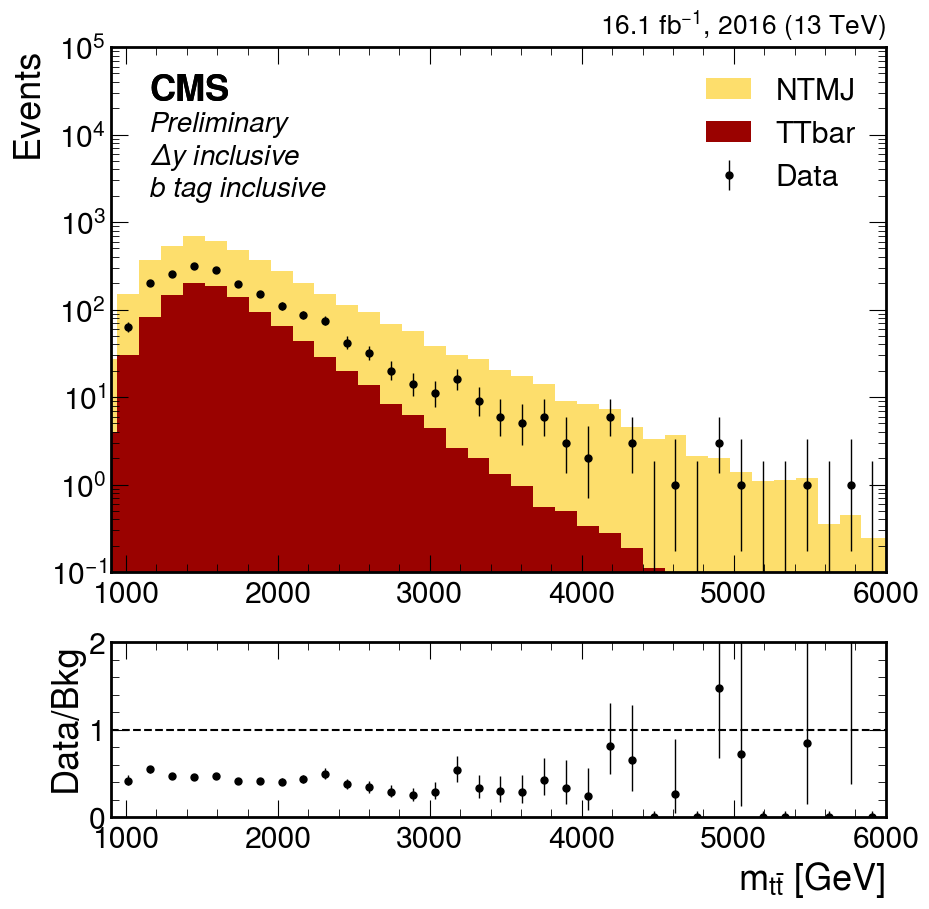

In [7]:
for IOV in IOVs:
    
    if '2016all' in IOV:
        
        httbar_apv = getHist('ttbarmass', 'TTbar', False, '2016APV', sum_axes=['anacat','systematic'], integrate_axes={'anacat':signal_cats})
        hntmj_apv = getHist('ttbarmass', 'JetHT', True, '2016APV', sum_axes=['anacat','systematic'], integrate_axes={'anacat':pretag_cats})
        hdata_apv = getHist('ttbarmass', 'JetHT', False, '2016APV', sum_axes=['anacat','systematic'], integrate_axes={'anacat':signal_cats})
        
        httbar_noapv = getHist('ttbarmass', 'TTbar', False, '2016APV', sum_axes=['anacat','systematic'], integrate_axes={'anacat':signal_cats})
        hntmj_noapv = getHist('ttbarmass', 'JetHT', True, '2016APV', sum_axes=['anacat','systematic'], integrate_axes={'anacat':pretag_cats})
        hdata_noapv = getHist('ttbarmass', 'JetHT', False, '2016APV', sum_axes=['anacat','systematic'], integrate_axes={'anacat':signal_cats})
    
    
        httbar = httbar_apv + httbar_noapv
        hntmj = hntmj_apv + hntmj_noapv
        hdata = hdata_apv + hdata_noapv

    else:
        
        httbar = getHist('ttbarmass', 'TTbar', False, IOV, sum_axes=['anacat','systematic'], integrate_axes={'anacat':signal_cats})
        hntmj = getHist('ttbarmass', 'JetHT', True, IOV, sum_axes=['anacat','systematic'], integrate_axes={'anacat':pretag_cats})
        hdata = getHist('ttbarmass', 'JetHT', False, IOV, sum_axes=['anacat','systematic'], integrate_axes={'anacat':signal_cats})

    text = 'Preliminary'+'\n'+r'$\Delta y$ inclusive'+'\n'+r'b tag inclusive'
    
    plotBackgroundEstimate(hdata, hntmj, httbar, IOV, text)

    plt.savefig(f'images/png/closureTest/{IOV}/closuretest_inclusive.png')
    plt.savefig(f'images/pdf/closureTest/{IOV}/closuretest_inclusive.pdf')

#     plt.show()


## plot background estimate (by category)

/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:190: RuntimeWarning: invalid value encountered in divide
  ufunc(
/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:196: RuntimeWarning: invalid value encountered in divide
  ufunc(


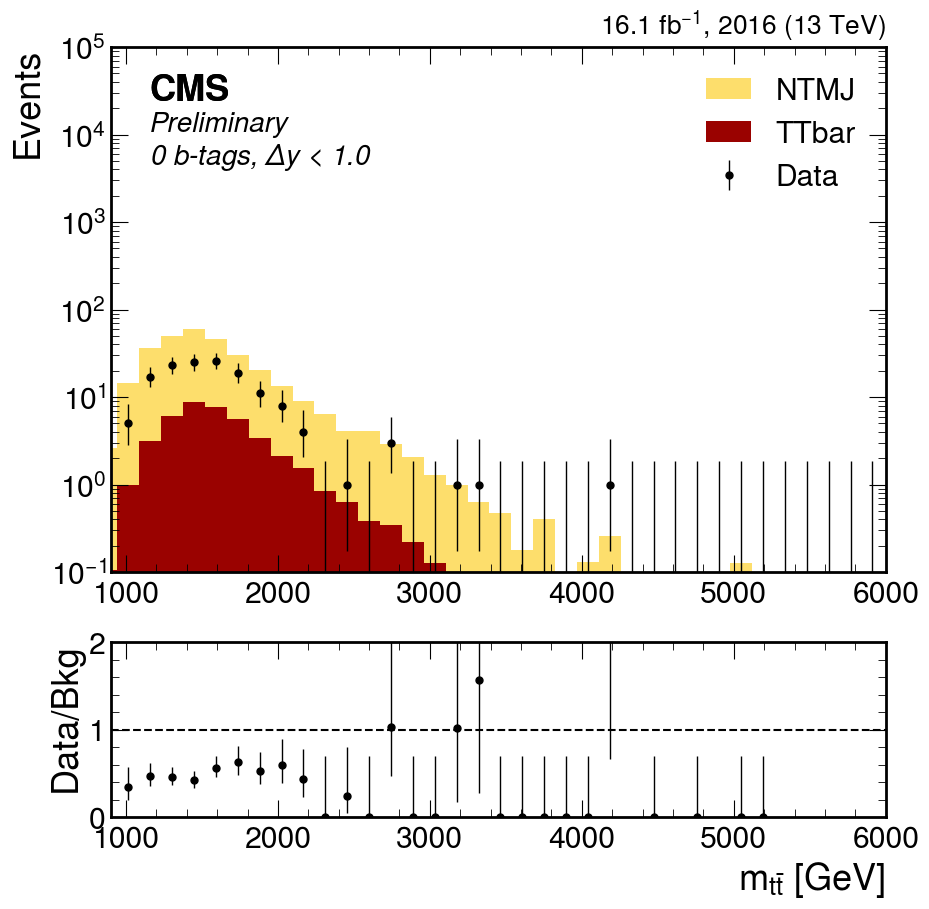

/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:190: RuntimeWarning: invalid value encountered in divide
  ufunc(
/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:196: RuntimeWarning: invalid value encountered in divide
  ufunc(


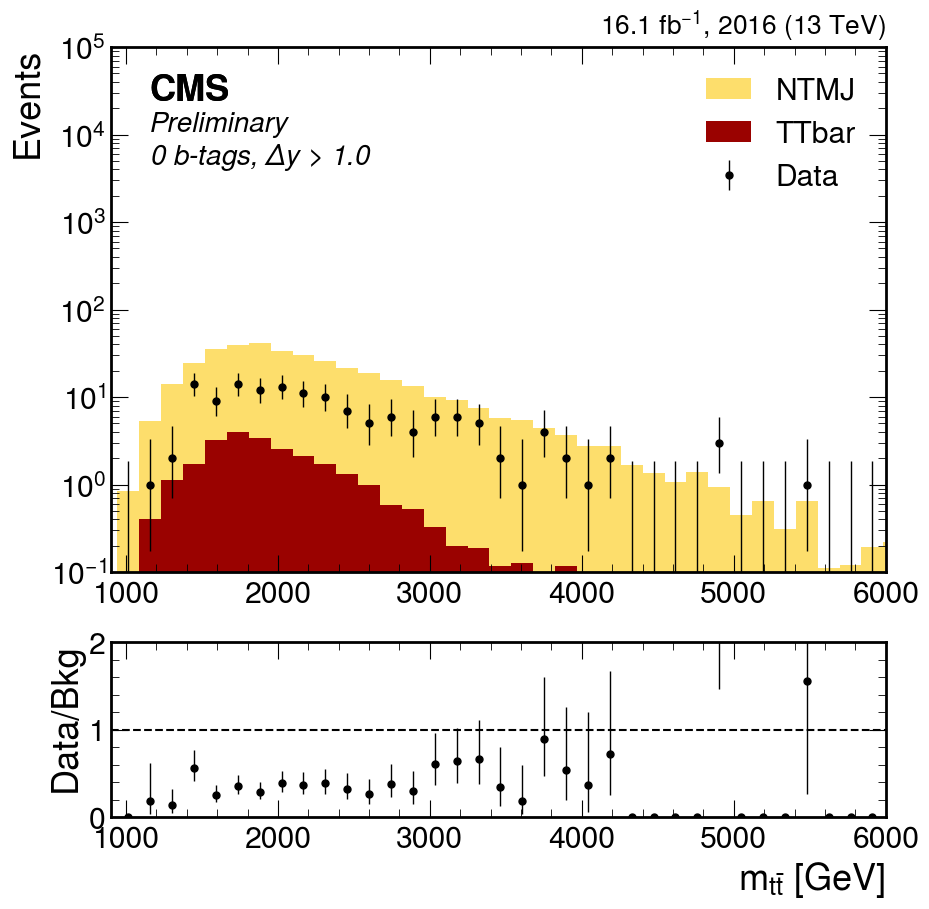

/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:190: RuntimeWarning: invalid value encountered in divide
  ufunc(
/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:196: RuntimeWarning: invalid value encountered in divide
  ufunc(


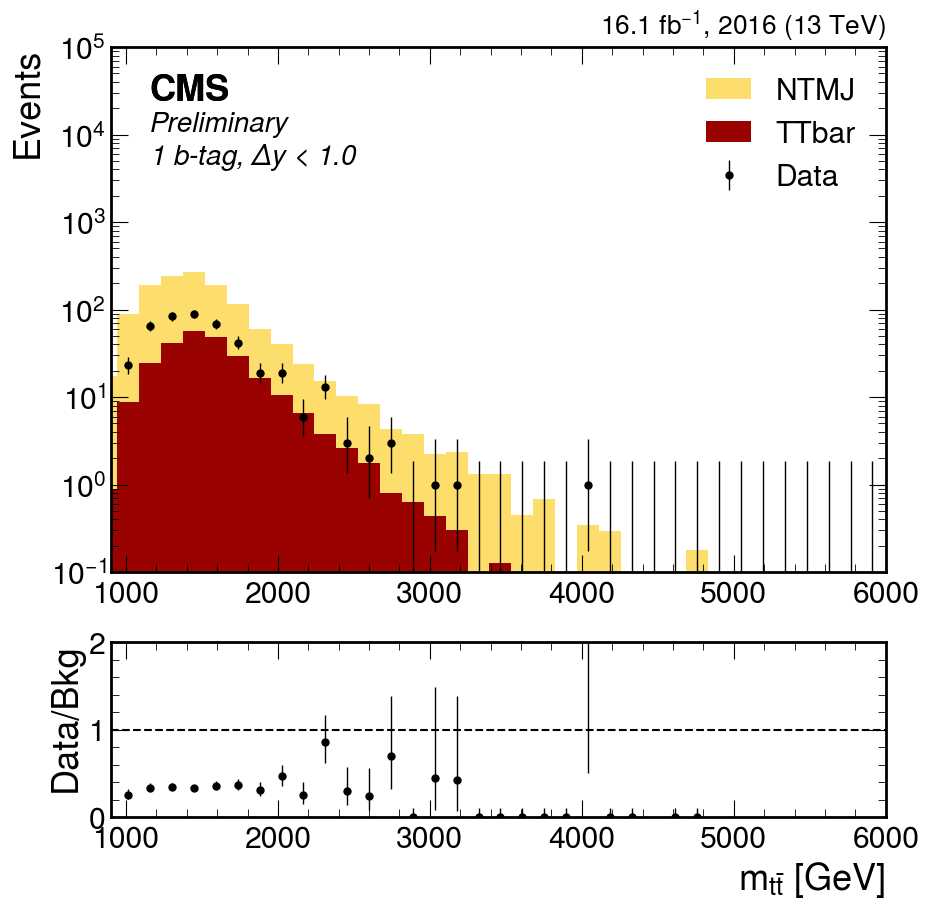

/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:190: RuntimeWarning: invalid value encountered in divide
  ufunc(
/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:196: RuntimeWarning: invalid value encountered in divide
  ufunc(


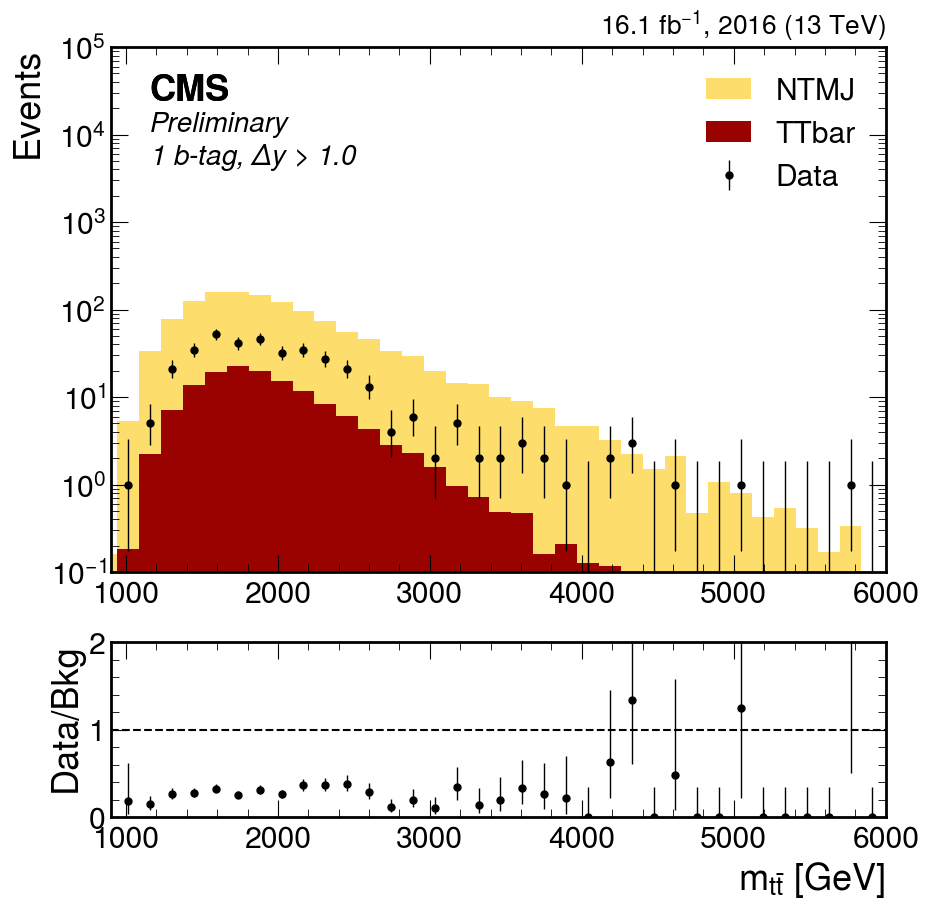

/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:190: RuntimeWarning: invalid value encountered in divide
  ufunc(
/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:196: RuntimeWarning: invalid value encountered in divide
  ufunc(


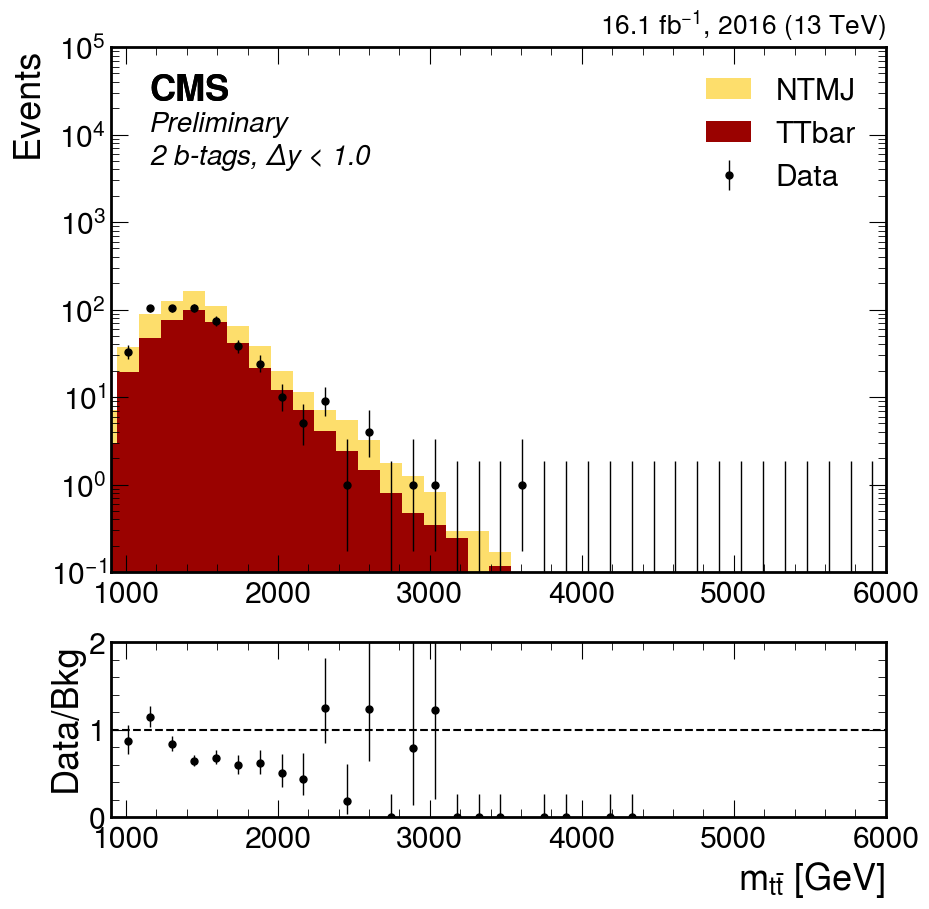

/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:190: RuntimeWarning: invalid value encountered in divide
  ufunc(
/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:196: RuntimeWarning: invalid value encountered in divide
  ufunc(


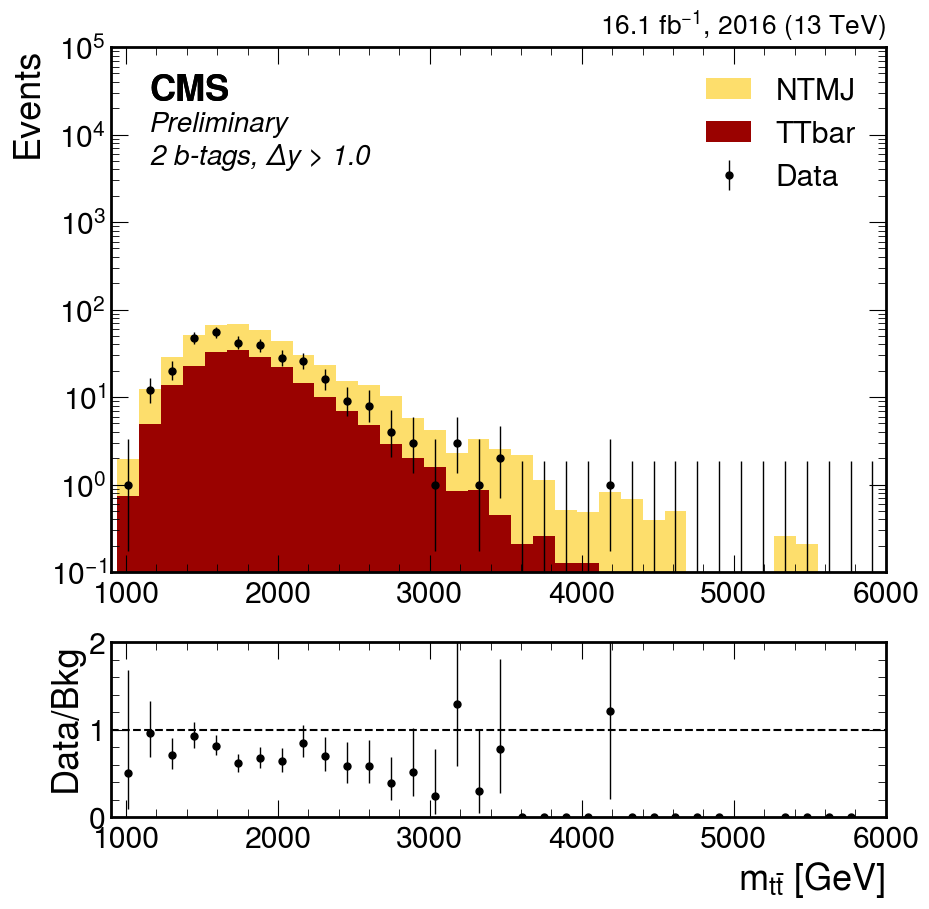

saving images/png/closureTest/2016/closuretest_0bcen.png
saving images/png/closureTest/2016/closuretest_0bfwd.png
saving images/png/closureTest/2016/closuretest_1bcen.png
saving images/png/closureTest/2016/closuretest_1bfwd.png
saving images/png/closureTest/2016/closuretest_2bcen.png
saving images/png/closureTest/2016/closuretest_2bfwd.png

saving images/pdf/closureTest/2016/closuretest_0bcen.pdf
saving images/pdf/closureTest/2016/closuretest_0bfwd.pdf
saving images/pdf/closureTest/2016/closuretest_1bcen.pdf
saving images/pdf/closureTest/2016/closuretest_1bfwd.pdf
saving images/pdf/closureTest/2016/closuretest_2bcen.pdf
saving images/pdf/closureTest/2016/closuretest_2bfwd.pdf


<Figure size 1000x1000 with 0 Axes>

In [8]:



cats = ['0bcen', '0bfwd', '1bcen', '1bfwd', '2bcen', '2bfwd']

for IOV in IOVs:
    
    for cat in cats:
        
        signal_cat = label_to_int_dict['2t'+cat]
        pretag_cat = label_to_int_dict['pret'+cat]
    
        if '2016all' in IOV:

            httbar_apv = getHist('ttbarmass', 'TTbar', False, '2016APV', sum_axes=['systematic'], integrate_axes={'anacat':signal_cat})
            hntmj_apv = getHist('ttbarmass', 'JetHT', True, '2016APV',   sum_axes=['systematic'], integrate_axes={'anacat':pretag_cat})
            hdata_apv = getHist('ttbarmass', 'JetHT', False, '2016APV',  sum_axes=['systematic'], integrate_axes={'anacat':signal_cat})

            httbar_noapv = getHist('ttbarmass', 'TTbar', False, '2016APV', sum_axes=['systematic'], integrate_axes={'anacat':signal_cat})
            hntmj_noapv = getHist('ttbarmass', 'JetHT', True, '2016APV',   sum_axes=['systematic'], integrate_axes={'anacat':pretag_cat})
            hdata_noapv = getHist('ttbarmass', 'JetHT', False, '2016APV',  sum_axes=['systematic'], integrate_axes={'anacat':signal_cat})


            httbar = httbar_apv + httbar_noapv
            hntmj = hntmj_apv + hntmj_noapv
            hdata = hdata_apv + hdata_noapv

        else:

            httbar = getHist('ttbarmass', 'TTbar', False, IOV, sum_axes=['systematic'], integrate_axes={'anacat':signal_cat})
            hntmj = getHist('ttbarmass', 'JetHT', True, IOV,   sum_axes=['systematic'], integrate_axes={'anacat':pretag_cat})
            hdata = getHist('ttbarmass', 'JetHT', False, IOV,  sum_axes=['systematic'], integrate_axes={'anacat':signal_cat})

        
        dytext = ''
        if 'cen' in cat:
            dytext = r'$\Delta y$ < 1.0'
        elif 'fwd' in cat:
            dytext = r'$\Delta y$ > 1.0'

        btext = ''
        if '0b' in cat:
            btext = '0 b-tags'
        elif '1b' in cat:
            btext = '1 b-tag'
        elif '2b' in cat:
            btext = '2 b-tags'

        text = f'Preliminary\n{btext}, {dytext} \n'
        
        hepplot = plotBackgroundEstimate(hdata, hntmj, httbar, IOV, text)

        savefilename = f'images/png/closureTest/{IOV}/closuretest_{cat}.png'
        plt.savefig(savefilename)
        plt.savefig(savefilename.replace('png', 'pdf'))

        plt.show()
        
        
        
        
# print image file locations
for IOV in IOVs:
    for cat in cats:
        print('saving', f'images/png/closureTest/{IOV}/closuretest_{cat}''.png' )       
    print()
    for cat in cats:
        print('saving', f'images/pdf/closureTest/{IOV}/closuretest_{cat}''.pdf')

        plt.savefig(f'images/png/closureTest/{IOV}/closuretest_inclusive.png')
        plt.savefig(f'images/pdf/closureTest/{IOV}/closuretest_inclusive.pdf')


